# Notebook For Figure 2 Method Paper

# 1. Importing necessary libraries and general functions  

In [1]:
import os
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import numpy as np
import pickle
import similaritymeasures as sm

plt.style.use('paper.mplstyle')



# 2. Select mice that will be analysed in the figure
### Define the data_folder where your MOU* folders are, enter the list of mice (MOU* folders), define the sessions that will be used for each animals

In [2]:
# defining data folder path and mice list

# path_to_data_folder is the path of the folder where you store the folders of your different mice.

path_to_data_folder='/LocalData/ForagingMice/MashaData/'
# path_to_data_folder='/LocalData/ForagingMice/4TowersTaskMethodPaper_Data/MaudData/'

#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/AurelienData/'

# Analysing the entire group of mice

mice_control = ["MOU21_1", "MOU21_2", "MOU21_3", "MOU21_4", "MOU21_5", "MOU21_6"]
mice_treated = ["MOU29_1", "MOU29_2", "MOU29_3", "MOU29_4", "MOU29_5"]

# mice_control = ['MOU3987', 'MOU3988', 'MOU4562', 'MOU4563', 'MOU4623', 'MOU4988', 'MOU4993']
# mice_treated = ['MOU3974', 'MOU3975', 'MOU3991', 'MOU3992', 'MOU4551', 'MOU4552', 'MOU4560', 'MOU4561', 'MOU4964', 'MOU4965', 'MOU4986', 'MOU4987', 'MOU5007', 'MOU5008']

# Verify that all folders in mice_to_analyse are present in path_to_data_folder
missing_folders = [mouse for mouse in mice_control if not os.path.isdir(os.path.join(path_to_data_folder, mouse))]
missing_folders = [mouse for mouse in mice_treated if not os.path.isdir(os.path.join(path_to_data_folder, mouse))]


if missing_folders:
    print("Missing mice folders:", missing_folders)
else:
    print("All mice folders are present in data folder.")

# Print the number of mice, the list of mice
print(f' {len(mice_control)} {"mice" if len(mice_control) > 1 else "mouse"} will be analysed\n')
print(f' {len(mice_treated)} {"mice" if len(mice_treated) > 1 else "mouse"} will be analysed\n')

# Select the number of sessions that will be analysed for each mice knowing the analysis starts with the first session (familiarisation)
first_and_last_session_indexes = [0,22]
# Select the offset to apply to the number of the sessions when plotting. By default, it is equal to the number of the first session.
# It resulsts in sessions being named respectively to their actual positions in the data set. TODO: Should reformulate this 
session_index_offset = first_and_last_session_indexes[0]

All mice folders are present in data folder.
 6 mice will be analysed

 5 mice will be analysed



# 3. Chosing illustration mice and sessions  

In [3]:
# Set the limits of the x-axis on the statistics plots
xlim_stats = [first_and_last_session_indexes[0]+0.5,first_and_last_session_indexes[1]+0.5]

# 4. General functions

In [4]:
def force_aspect(ax, ratio=1):
    """
    Force the aspect ratio of the given axis (ax) to a specific ratio.
    The ratio parameter allows scaling of the aspect ratio. Default is 1.
    
    Arguments:
        ax (matplotlib.axes.Axes): Matplotlib axis object for plotting.
        ratio (float, optional): Ratio of the figure's dimensions
    
    """
    
    ratio = 1.0  # Set ratio to 1.0, making the aspect ratio 1:1 by default
    
    # Get the current limits of the x and y axes
    x_left, x_right = ax.get_xlim()  # Get the left and right x-axis limits
    y_low, y_high = ax.get_ylim()    # Get the lower and upper y-axis limits
    
    # Calculate the new aspect ratio and set it
    # The formula is the absolute ratio of the width and height, adjusted by the given ratio
    ax.set_aspect(abs((x_right - x_left) / (y_low - y_high)) * ratio)

def cm2inch(value):

    """
    Converts centimeters to inches for figure size.

    Arguments:
        value (float): value to convert in cm 

    """

    return value/2.54

def compute_average_direction(points):

    """
    Compute the average direction of a trajectory portion, assuming the coordinates are in chronological order.

    Arguments:
        points (2D numpy.array): Trajectory of which the average direction will be computed

    Outputs:
        avg_diff (1D numpy.array): vector pointing to the average direction
        angle (float): angle of the vector with the x-axis 
    """
    
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

def finding_mouse_rewarded_direction(folder_path_mouse_to_process, session_index):
    
    """
    Determines the rewarded direction for the session corresponding to the input index of a given mouse. 
    This index is relative to the session position in the series of analysed sessions.
    This input index can have an offset. This is usefull if the sessions series analysed does not start with the first session. 
    
    Arguments:
        folder_path_mouse_to_process (str): Path to the folder containing mouse sessions folders.
        session_index (int): Index of the session that will be used to define the rewarded direction

    Returns:
        str: 'CW' (Clockwise) if the rewarded direction is 270 degrees,
             'CCW' (Counterclockwise) if the rewarded direction is 90 degrees,
             numpy.nan if reward delivery is not allowed 
             None if an error occurs or if both directions are rewarded.
    """
    
    # Get all session folders that start with 'MOU' and sort them
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    # Load data from the last session
    session_traj_df, session_turns_df, session_param_df = load_data(folder_path_mouse_to_process, sessions_to_process[session_index])

    # Extract rewarded direction in degrees
    rewarded_direction_degrees = session_param_df["potentialRewardedDirections"][0]

    # Check if reward delivery is allowed
    if session_param_df["allowRewardDelivery"][0]:

        # Determine the rewarded direction based on the extracted value
        if rewarded_direction_degrees == '[270]':
            rewarded_direction = 'CW'  # Clockwise

        elif rewarded_direction_degrees == '[90]':
            rewarded_direction = 'CCW'  # Counterclockwise
        
        elif rewarded_direction_degrees == '[90, 270]':
            rewarded_direction = 'both'  # Clockwise and Counterclockwise

        # Returns None if the rewarded direction entry in session_param_df is not recognized
        else:
            print('ERROR: Unexpected rewarded direction value:', rewarded_direction_degrees)
            return None  # Explicitly return None to indicate failure
    
    else:

        # Rewarded direction is set to X if reward delivery os not allowed
        rewarded_direction = 'X'

    return rewarded_direction


def plot_learning_curves(mice_group_metric_persession, ax, show_individual_mice=True,
                         colors=None, show_xlabel=True, ylabel='', main_lines_labels=None, 
                         tick_interval=1, index_offset=0, xlim=[None,None], ylim=None, show_legend=True, legend_loc=(0.05, 0.9)):
    """
    Plots a given metric across sessions for multiple mice groups (also called a learning curves).

    Arguments:

        mice_group_metric_persession (list): list of dictionnaries where keys are mouse IDs and values are lists of (session_index, value) lists.
        mice_to_highlight_labels (list, optional): List of the label of the mice to highlight.
        show_individual_mice (bool): If true, plot a line for each individual mouse.
        ax (matplotlib.axes.Axes): Axes object for plotting.
        show_xlabel (bool, optional): Whether to display the x-axis label. Defaults to True.
        ylabel (str, optional): Label for the y-axis.
        main_lines_labels (list, optional): Labels of the median and quartiles range for each group.
        tick_interval (int, optional): Interval for x-axis tick marks. Defaults to 1.
        index_offset (int, optional): Offset to apply to the numbers in the x axis. Use it if you want to the first sessions to be named '1'.
        xlim (tuple, optional): Tuple specifying x-axis limits. Defaults to None.
        ylim (tuple, optional): Tuple specifying y-axis limits. Defaults to None.
        show_legend (bool, optional): Whether to show the legend. Defaults to True.
        legend_loc (tupple, optional): Location of the legend.
    """

    all_session_indices = set()  # Track all session indices across selected mice
    values_per_session = {}  # Store values for each session across mice

    mice_to_plot = []
    mice_to_plot_per_group = []
    mice_metric_persession = {}

    for group in mice_group_metric_persession:

        mice_to_plot = mice_to_plot + list(group.keys())
        mice_to_plot_per_group.append(list(group.keys()))
        mice_metric_persession.update(group)
    
    if not(colors):
        colors = ['black']*len(mice_group_metric_persession)

    # Loop through each mouse and gather session data
    for mouse in mice_to_plot:

        if mouse not in mice_metric_persession:
            print(f"Mouse {mouse} not found in data. Skipping.")
            continue    

        # Selecting the sub-list of sessions to analyse
        sessions = mice_metric_persession[mouse]

        # Extract session indices and corresponding values
        session_indices = [session[0] for session in sessions]
        values = [session[1] for session in sessions]

        # Update session index tracking
        all_session_indices.update(session_indices)
        for session, value in sessions:
            if session not in values_per_session:
                values_per_session[session] = []
            values_per_session[session].append(value)

    ################################################################


    # Convert session indices to a sorted list
    sorted_sessions = sorted(all_session_indices)

    group_starting_index = 0

    for n, group in enumerate(mice_group_metric_persession):

        group_length = len(group)
        print(group_length)

        # Compute median and 25th-75th percentile range for each session
        median_values = []
        lower_quartile = []
        upper_quartile = []

        for session in sorted_sessions:
            session_values = values_per_session[session][group_starting_index:group_starting_index+group_length]
            median_values.append(np.nanmedian(session_values))
            lower_quartile.append(np.nanpercentile(session_values, 25))
            upper_quartile.append(np.nanpercentile(session_values, 75))

        median_values = np.array(median_values)
        lower_quartile = np.array(lower_quartile)
        upper_quartile = np.array(upper_quartile)

        # If the median and quartiles range don't have a label, give them a default label.
        if not main_lines_labels:

            main_line_label = f'Group {n} Median \u00B1 Quartiles, n={len(mice_to_plot)}'

        else:

            main_line_label = main_lines_labels[n]

        # Plot median learning curve with shaded 25th-75th percentile range
        ax.errorbar(np.array(sorted_sessions)+index_offset, median_values, yerr=[median_values-lower_quartile, upper_quartile-median_values], alpha=1, color=colors[n], linewidth = 1, label=main_line_label, zorder=50*len(colors[n]))

        group_starting_index += group_length # CHANGED BY TOM. WAS PREVIOUSLY : group_starting_index += 1

    ################################################################

    for g in range(len(mice_to_plot_per_group)):

        if not(show_individual_mice):
            break

        for mouse in mice_to_plot_per_group[g]:

            if mouse not in mice_metric_persession:
                print(f"Mouse {mouse} not found in data. Skipping.")
                continue    

            # Selecting the sub-list of sessions to analyse
            sessions = mice_metric_persession[mouse]

            # Extract session indices and corresponding values
            session_indices = [session[0] for session in sessions]
            values = [session[1] for session in sessions]

            # Check if there is a nan value in the values list and remove it to allow plotting of lines between points with values
            if sum(np.isnan(x) for x in values)>0:

                session_indices_array=np.array(session_indices)
                values_array=np.array(values)
                mask = ~np.isnan(values_array)
                session_indices=session_indices_array[mask]
                values=values_array[mask]

            color = colors[g]
            ax.plot(np.array(session_indices)+index_offset, values, marker='o', linewidth=0.5, markersize=1, alpha=0.3, markeredgewidth=0.0, color=color)

            # Update session index tracking
            all_session_indices.update(session_indices)
            for session, value in sessions:
                if session not in values_per_session:
                    values_per_session[session] = []
                values_per_session[session].append(value)

    ################################################################

    # Set axis labels and formatting
    if show_xlabel:
        ax.set_xlabel('Session Number', fontsize=7)
    
    ax.set_ylabel(ylabel, fontsize=7)

    # Ensure x-axis labels are integers
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set x-ticks at specified intervals
    if all_session_indices:
        max_index = max(all_session_indices)
        ax.set_xticks(range(1+index_offset, max_index + 1+index_offset, tick_interval))

    # Apply x and y axis limits if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)

    # Show legend if required
    if show_legend:

        ax.legend(frameon=False, loc=legend_loc)
        


# 5. Panel A, B, E

The next two functions are used to:
- Find the times at which TATs occured.
- Find the time at which the number of TATs becomes higher than a given threshold.

In [5]:
def cumulated_reward_time_profile(folder_path_mouse_to_process, session_to_process):
    """
    Computes the cumulative number of rewarded and unrewarded runs around a tower at each time a new run around a tower occurs, for a given session and a given mouse.

    Arguments:
        folder_path_mouse_to_process (str): Path to the folder containing mouse session data.
        session_to_process (str): Name of the session to be processed.
        reference_session_index (int): Index of the session that will be used to define the rewarded direction
        
    Returns:
        tuple: Two lists containing:
            - (rewarded_turns_time, cumulated_rewarded_turns): Sorted times and cumulative counts of rewarded turns.
            - (unrewarded_turns_time, cumulated_unrewarded_turns): Sorted times and cumulative counts of unrewarded turns.
    """

    # Construct the path to the session pickle file
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    # Load session data from the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    # Deep copy the list of turn epochs
    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_around_tower'])

    # Initialize lists to store filtered turns
    time_of_rewarded_runsaroundtower = []
    time_of_unrewarded_runsaroundtower = []

    # Iterate through each recorded turn around the tower
    for run_around_tower in runs_around_tower:

        # Categorize turns based on whether or not they were rewarding
        if run_around_tower[3]['Rewarded']:
            time_of_rewarded_runsaroundtower.append(run_around_tower[4]['epoch_time'])
        else: 
            time_of_unrewarded_runsaroundtower.append(run_around_tower[4]['epoch_time'])

    # Sort the turn times for cumulative calculations
    rewarded_times_sorted = np.sort(time_of_rewarded_runsaroundtower)
    unrewarded_times_sorted = np.sort(time_of_unrewarded_runsaroundtower)

    # Compute cumulative counts for each direction
    rewarded_cumulative = np.arange(1, len(rewarded_times_sorted) + 1)
    unrewarded_cumulative = np.arange(1, len(unrewarded_times_sorted) + 1)
    
    return [rewarded_times_sorted, rewarded_cumulative], [unrewarded_times_sorted, unrewarded_cumulative]

def accumulation_threshold(cummulated_events_time, threshold_fraction=0.8):

    """
    Compute the first time point at which the cummulated number of event in cummulated_events_time
    is above a threshold, that is a fraction (80% by default) of the total number of events.
    
    Arguments:
        cummulated_events_time (list): list of time at which one event occurs.
        threshold_fraction (float, optional): fraction of the total number of event that will used as threshold. 

    Returns:
        float: first value in cummulated_events_time that is above the
        
    """

    # Compute the total number of events
    total_events = len(cummulated_events_time)

    if total_events==0:

        return(np.nan)

    # Initialise index of the first event
    i = 0

    # Compute the fraction of cummulated events
    fraction_of_events = (i+1)/total_events if total_events!=0 else 0

    # Iterate while the fraction of cummulated events is lower than the threshold fraction 
    while fraction_of_events<threshold_fraction:

        # Increase the index
        i = i + 1
        # Update the fraction of cummulated events at the new index
        fraction_of_events = (i+1)/total_events if total_events!=0 else 0

    # Return the first time in cummulated_events_time at which the fraction of cummulated events is higher than threshold_fraction.  
    return cummulated_events_time[i]

### Here will be computed and stored metrics related to the number of TATs that will be plotted for each mouse across sessions. Those metrics are:
- The number of turns in rewarding direction
- The ratio of the difference of the number of CCW and CW turns with respect to the total number of turns. We call it the CCW vs CW normalized difference.    
$ \frac{N_{CCW}-N_{CW}}{N_{CCW}+N_{CW}} $
- The time that the mouse took to perform 80% of the total number of turns in rewarded direction of the session. 

In [6]:
# Initialize dictionaries to store the various metrics for each mouse
mice_rewarded_tats_persession_1 = {mouse: [] for mouse in mice_control}
mice_unrewarded_tats_persession_1 = {mouse: [] for mouse in mice_control}
mice_cw_vs_ccw_norm_diff_persession_1 = {mouse: [] for mouse in mice_control}
mice_rewarded_tats_threshold_persession_1 = {mouse: [] for mouse in mice_control}
mice_distance_run_persession_1 = {mouse: [] for mouse in mice_control}

# Iterate through each mouse to process its data
for mouse in mice_control:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    # limit the analysis to the subseet of session we want to analyse
    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_process, '\n')


    # Process each session for the current mouse
    for session_index, session_to_process in enumerate(sessions_to_process):

        
        # Define the pickle file path for the session
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

        # Check if the pickle file exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            # Append session Nan data to the respective dictionaries
            mice_cw_vs_ccw_norm_diff_persession_1[mouse].append([session_index + 1, np.nan])
            mice_rewarded_tats_persession_1[mouse].append([session_index + 1, np.nan])
            mice_unrewarded_tats_persession_1[mouse].append([session_index + 1, np.nan])
            #mice_rewarded_tats_threshold_persession_1[mouse].append([session_index + 1, np.nan])
            continue  # Skip to the next session if the pickle file does not exist

        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        # Determine the rewarded direction for all sessions of the current mouse
        rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process, first_and_last_session_indexes[0]+session_index)

        
        # Extract run around tower results from the session data
        run_around_tower_sessionresult = session_data['run_around_tower_sessionresult']
        total_TATs = run_around_tower_sessionresult['All']['total_CCW'] + run_around_tower_sessionresult['All']['total_CW']
        cw_vs_ccw_norm_diff = (run_around_tower_sessionresult['All']['total_CW'] - run_around_tower_sessionresult['All']['total_CCW'])/(total_TATs)
        rewarded_TATs = run_around_tower_sessionresult['All']['rewarded_CCW'] + run_around_tower_sessionresult['All']['rewarded_CW']
        distance_run_during_session = session_data['distance_ran']
        # Compute cumulated turns time profiles for turns in rewarded and unrewarded direction
            
        [rewarded_times_sorted, rewarded_cumulative], [unrewarded_times_sorted, unrewarded_cumulative] = cumulated_reward_time_profile(folder_path_mouse_to_process, session_to_process)

        # Determine the rewarded direction turns threshold time
        rewarded_tats_threshold_time = accumulation_threshold(rewarded_times_sorted)

        # If reward delivery is not allowed, set to numpy.nan the metrics values concerning rewarded direction
        if rewarded_direction == 'X':
           
            # Append session data to the respective dictionaries
            mice_distance_run_persession_1[mouse].append([session_index + 1, distance_run_during_session])
            mice_cw_vs_ccw_norm_diff_persession_1[mouse].append([session_index + 1, cw_vs_ccw_norm_diff])
            mice_rewarded_tats_persession_1[mouse].append([session_index + 1, np.nan])
            mice_unrewarded_tats_persession_1[mouse].append([session_index + 1, np.nan])
            mice_rewarded_tats_threshold_persession_1[mouse].append([session_index + 1, np.nan])
            
        else:        

            # Append session data to the respective dictionaries
            mice_distance_run_persession_1[mouse].append([session_index + 1, distance_run_during_session])
            mice_cw_vs_ccw_norm_diff_persession_1[mouse].append([session_index + 1, cw_vs_ccw_norm_diff])
            mice_rewarded_tats_persession_1[mouse].append([session_index + 1, rewarded_TATs])
            mice_unrewarded_tats_persession_1[mouse].append([session_index + 1, total_TATs-rewarded_TATs])
            mice_rewarded_tats_threshold_persession_1[mouse].append([session_index + 1, rewarded_tats_threshold_time])


Mouse MOU21_1. There is/are 22 sessions:
['MOU21_1_20250417-0803', 'MOU21_1_20250417-1259', 'MOU21_1_20250418-0800', 'MOU21_1_20250418-1253', 'MOU21_1_20250419-0758', 'MOU21_1_20250419-1319', 'MOU21_1_20250420-0758', 'MOU21_1_20250420-1300', 'MOU21_1_20250421-0801', 'MOU21_1_20250421-1301', 'MOU21_1_20250422-0759', 'MOU21_1_20250422-1259', 'MOU21_1_20250423-0756', 'MOU21_1_20250423-1251', 'MOU21_1_20250424-0800', 'MOU21_1_20250424-1258', 'MOU21_1_20250425-0803', 'MOU21_1_20250425-1251', 'MOU21_1_20250426-0809', 'MOU21_1_20250426-1315', 'MOU21_1_20250427-0802', 'MOU21_1_20250427-1253'] 

Pickle file does not exist for session MOU21_1_20250421-0801, skipping .....
Mouse MOU21_2. There is/are 22 sessions:
['MOU21_2_20250417-0837', 'MOU21_2_20250417-1329', 'MOU21_2_20250418-0831', 'MOU21_2_20250418-1323', 'MOU21_2_20250419-0826', 'MOU21_2_20250419-1347', 'MOU21_2_20250420-0827', 'MOU21_2_20250420-1329', 'MOU21_2_20250421-0830', 'MOU21_2_20250421-1329', 'MOU21_2_20250422-0827', 'MOU21_2_202

In [10]:
# Initialize dictionaries to store the various metrics for each mouse
mice_rewarded_tats_persession_2 = {mouse: [] for mouse in mice_treated}
mice_unrewarded_tats_persession_2 = {mouse: [] for mouse in mice_treated}
mice_cw_vs_ccw_norm_diff_persession_2 = {mouse: [] for mouse in mice_treated}
mice_rewarded_tats_threshold_persession_2 = {mouse: [] for mouse in mice_treated}
mice_distance_run_persession_2 = {mouse: [] for mouse in mice_treated}

# Iterate through each mouse to process its data
for mouse in mice_treated:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    # limit the analysis to the subseet of session we want to analyse
    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_process, '\n')

    # Deterine the first unique rewarded direction of the session series
    first_rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process, 4)

    # Process each session for the current mouse
    for session_index, session_to_process in enumerate(sessions_to_process):

        
        # Define the pickle file path for the session
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

        # Check if the pickle file exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            # Append session Nan data to the respective dictionaries
            mice_cw_vs_ccw_norm_diff_persession_2[mouse].append([session_index + 1, np.nan])
            mice_rewarded_tats_persession_2[mouse].append([session_index + 1, np.nan])
            mice_unrewarded_tats_persession_2[mouse].append([session_index + 1, np.nan])
            #mice_rewarded_tats_threshold_persession_2[mouse].append([session_index + 1, np.nan])
            continue  # Skip to the next session if the pickle file does not exist

        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        # Determine the rewarded direction for all sessions of the current mouse
        rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process, first_and_last_session_indexes[0]+session_index)

        
        # Extract run around tower results from the session data
        run_around_tower_sessionresult = session_data['run_around_tower_sessionresult']
        total_TATs = run_around_tower_sessionresult['All']['total_CCW'] + run_around_tower_sessionresult['All']['total_CW']
        cw_vs_ccw_norm_diff = (run_around_tower_sessionresult['All']['total_CW'] - run_around_tower_sessionresult['All']['total_CCW'])/(total_TATs)
        rewarded_TATs = run_around_tower_sessionresult['All']['rewarded_CCW'] + run_around_tower_sessionresult['All']['rewarded_CW']
        distance_run_during_session = session_data['distance_ran']

        # Compute cumulated turns time profiles for rewarded and unrewarded turns
        
        [rewarded_times_sorted, rewarded_cumulative], [unrewarded_times_sorted, unrewarded_cumulative] = cumulated_reward_time_profile(folder_path_mouse_to_process, session_to_process)

        # Determine the rewarded direction turns threshold time
        rewarded_tats_threshold_time = accumulation_threshold(rewarded_times_sorted)

        # If reward delivery is not allowed, set to numpy.nan the metrics values concerning rewards

        if rewarded_direction == 'X':
           
            # Append session data to the respective dictionaries
            mice_distance_run_persession_2[mouse].append([session_index + 1, distance_run_during_session])
            mice_cw_vs_ccw_norm_diff_persession_2[mouse].append([session_index + 1, cw_vs_ccw_norm_diff])
            mice_rewarded_tats_persession_2[mouse].append([session_index + 1, np.nan])
            mice_unrewarded_tats_persession_2[mouse].append([session_index + 1, np.nan])
            mice_rewarded_tats_threshold_persession_2[mouse].append([session_index + 1, np.nan])

        else:        

            # Append session data to the respective dictionaries
            mice_distance_run_persession_2[mouse].append([session_index + 1, distance_run_during_session])
            mice_cw_vs_ccw_norm_diff_persession_2[mouse].append([session_index + 1, cw_vs_ccw_norm_diff])
            mice_rewarded_tats_persession_2[mouse].append([session_index + 1, rewarded_TATs])
            mice_unrewarded_tats_persession_2[mouse].append([session_index + 1, total_TATs-rewarded_TATs])
            mice_rewarded_tats_threshold_persession_2[mouse].append([session_index + 1, rewarded_tats_threshold_time])


Mouse MOU29_1. There is/are 22 sessions:
['MOU29_1_20250814-0817', 'MOU29_1_20250814-1302', 'MOU29_1_20250815-0801', 'MOU29_1_20250815-1302', 'MOU29_1_20250816-0801', 'MOU29_1_20250816-1319', 'MOU29_1_20250817-0803', 'MOU29_1_20250817-1416', 'MOU29_1_20250818-0804', 'MOU29_1_20250818-1303', 'MOU29_1_20250819-0818', 'MOU29_1_20250819-1311', 'MOU29_1_20250820-0823', 'MOU29_1_20250820-1311', 'MOU29_1_20250821-0828', 'MOU29_1_20250821-1320', 'MOU29_1_20250822-0827', 'MOU29_1_20250822-1330', 'MOU29_1_20250823-0826', 'MOU29_1_20250823-1329', 'MOU29_1_20250824-0804', 'MOU29_1_20250824-1338'] 

Mouse MOU29_2. There is/are 22 sessions:
['MOU29_2_20250814-0832', 'MOU29_2_20250814-1317', 'MOU29_2_20250815-0815', 'MOU29_2_20250815-1316', 'MOU29_2_20250816-0815', 'MOU29_2_20250816-1333', 'MOU29_2_20250817-0817', 'MOU29_2_20250817-1430', 'MOU29_2_20250818-0817', 'MOU29_2_20250818-1317', 'MOU29_2_20250819-0833', 'MOU29_2_20250819-1325', 'MOU29_2_20250820-0836', 'MOU29_2_20250820-1324', 'MOU29_2_20250

### The following cells will be used to compute the median of the Fréchet distance of each pair of flattened trajectories.

In [ ]:
def towers_coordinates_as_dictionnary(towers_coordinates_cm):
    
    """
    Converts a dictionary of tower coordinates into a structured dictionary 
    where each tower's coordinates are labeled with explicit corner names.

    Arguments:
        towers_coordinates_cm (dict): Dictionary where keys are tower names and 
                                      values are lists/tuples of four coordinates.

    Returns:
        dict: A dictionary mapping tower names to their respective coordinates, 
              labeled as 'NW' (North-West), 'NE' (North-East), 'SE' (South-East), 
              and 'SW' (South-West).
    """

    # Initialize a dictionary to store labeled coordinates
    towers_coordinates_as_dict = {}

    # Predefined corner names in the order expected from input coordinates
    corner_names = ['NW', 'NE', 'SE', 'SW']

    # Map each tower's coordinates to its corresponding corner names
    for tower, coordinates in towers_coordinates_cm.items():
        towers_coordinates_as_dict[tower] = {
            corner_names[i]: coord for i, coord in enumerate(coordinates)
        }

    return towers_coordinates_as_dict

def get_tower_and_corner(run_around_tower):

    """
    Get the label of the tower and corner around wich the run around tower is happened
    based on the second and third elements saved in run_around_tower: 'N' for north, 'S' for south, 'E' for east, 'W' for west.
    
    Argument:
        run_around_tower (list): a list containing information about a run around tower

    Returns:
        str: Name of the tower around which the run occured
        str: A two character string. The first character is the name of the starting trapeze,
             the last character is the name of the ending trapeze  
    """
    
    # Extract tower name, starting name and ending trapeze name 
    tower_name = run_around_tower[1][0]
    start_trapeze = run_around_tower[1][1]
    end_trapeze = run_around_tower[2][1]
    
    # Determine the corner based on the start and end faces
    if start_trapeze == 'W' and end_trapeze == 'S':
        corner = 'SW'
    elif start_trapeze == 'S' and end_trapeze == 'E':
        corner = 'SE'
    elif start_trapeze == 'E' and end_trapeze == 'N':
        corner = 'NE'
    elif start_trapeze == 'N' and end_trapeze == 'W':
        corner = 'NW'
    elif start_trapeze == 'W' and end_trapeze == 'N':
        corner = 'NW'
    elif start_trapeze == 'N' and end_trapeze == 'E':
        corner = 'NE'
    elif start_trapeze == 'E' and end_trapeze == 'S':
        corner = 'SE'
    elif start_trapeze == 'S' and end_trapeze == 'W':
        corner = 'SW'
    else:
        corner = None  # Handle unexpected cases
    
    return tower_name, corner

def cw_rotate_sw_trajectory_90_ccw(trajectory):
    
    """
    Rotates the input trajectory of 90° in counter-clockwise direction.

    Argument:
        trajectory (numpy.ndarray): A 2D numpy.ndarray of shape (2, X).

    Returns:
        numpy.ndarray: trajectory rotated by 90° counter-clockwise

    """
    
    # Define the roation matrix
    rotation_matrix = np.array([[0, -1], [1, 0]])
    
    # Returns the matrix product of the rotation matrix and the trajectory 
    return rotation_matrix @ trajectory

def rotate_nw_trajectory_180_ccw(trajectory):

    """
    Rotates the input trajectory of 180° in counter-clockwise direction.

    Argument:
        trajectory (numpy.ndarray): A 2D numpy.ndarray of shape (2, X).

    Returns:
        numpy.ndarray: trajectory rotated by 180° counter-clockwise

    """

    return -trajectory

def rotate_ne_trajectory_270_ccw(trajectory):
    
    """
    Rotates the input trajectory of 270° in counter-clockwise direction.

    Argument:
        trajectory (numpy.ndarray): A 2D numpy.ndarray of shape (2, X).

    Returns:
        numpy.ndarray: trajectory rotated by 270° counter-clockwise

    """
    
    # Define the roation matrix
    rotation_matrix = np.array([[0, 1], [-1, 0]])

    # Returns the matrix product of the rotation matrix and the trajectory 
    return rotation_matrix @ trajectory

def compute_frechet_distances(runs_list):

    """
    This function takes a list of trajectories of dimensions (2,N), computes the Fréchet distance 
    between each pairs of trajectories, and returns the median of those distances.
    
    Arguments:
        runs_list (list): List of trajectories of dimensions (2,N)

    Return:
        (float): Median of the Fréchet distances of all trajectories pairs
    
    """

    # Create an empty list that will contain the Fréchet distances of all trajectories pairs
    frechet_distances_list = []

    # Iterate on all trajectories
    for i in range(len(runs_list)):

        # Transpose the trajectory
        # This step is necessary as the function that computes the Fréchet distance takes as an argument trajectories of dimensions (N,2)
        traj_points_a = np.transpose(runs_list[i])

        # Iterate on every trajectories of higher ranks to create trajectories pairs
        # We do that so that no pairs is counted twice, as the Fréchet distance between trajectory A and B is the same as between B and A
        for j in range(i+1, len(runs_list)):

            # Transpose the trajectory
            traj_points_b = np.transpose(runs_list[j])

            # Compute the Fréchet distance for the current pair of trajectories
            frechet_distance = sm.frechet_dist(traj_points_a,traj_points_b)

            # Store the result in a list
            frechet_distances_list.append(frechet_distance)

    # Return the median of the list of Fréchet distances
    return frechet_distances_list


### This cell process the runs around tower trajectory such that:
- All runs around tower with the same starting and ending trapeze and are shifted to have the same origin, independently of the tower where they occur.
- All runs around tower are rotated from 90°/180°/270° counter-clockwise when the corner around which the mouse turns is South-West/North-West/North-East.
- Does so separately for turns in clockwise and counter-clockwise direction.

In [ ]:
# Initialize a dictionary to store all trajectories for each mouse, with empty lists for each session
mice_alltrajectories_persession_1 = {mouse: {} for mouse in mice_control}

# Initialize a dictionary to store realigned and rotated trajectories for each mouse, with empty dictionaries for each session
trajectories_per_session_realigned_rotated_1 = {mouse: {} for mouse in mice_control}

# Loop through each mouse in the list of mice to realign all their turns trajectory
for mouse in mice_control:
    # Define the folder path for the current mouse
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

    # Get a sorted list of session folders for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

    # Get the number of sessions to process
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')

    # Loop through each session for the current mouse to realign all the turns trajectory from those sessions
    for session_index, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {session_index}')

        # Define the path to the pickle file for the current session
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

          # Check if the pickle file exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue
        
        # Load the data from the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        # Initialize entries for the current session in the dictionaries
        mice_alltrajectories_persession_1[mouse][session_index] = []
        trajectories_per_session_realigned_rotated_1[mouse][session_index] = {'CW':[], 'CCW':[]}

        # Get the runs around the tower for the current session
        runs_around_tower = session_data['all_epochs']['run_around_tower']
        # Get the trajectory of the mouse
        positions = np.array(session_data['positions'])

        # Get the tower coordinates and convert them to a dictionary format
        towers_coordinates_cm = session_data['towers_coordinates_cm']
        towers_coordinates_as_dict = towers_coordinates_as_dictionnary(towers_coordinates_cm)

        # Loop through each run around the tower to realign them
        for run_around_tower in runs_around_tower:
            # Only process runs around tower where there was only one trapeze switch 
            if run_around_tower[3]['num_trapezeswitch'] == 1:
                # Extract the run trajectory
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                mice_alltrajectories_persession_1[mouse][session_index].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)

                # Access tower and corner coordinates from the dictionary
                if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
                    this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue

                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]
                this_trajectory = positions[:, start_idx:end_idx]

                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]

                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Rotate the trajectory based on the corner
                if corner == 'SW':
                    this_trajectory = cw_rotate_sw_trajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_nw_trajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_ne_trajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate list based on direction
                trajectories_per_session_realigned_rotated_1[mouse][session_index][direction].append(this_trajectory)

                

Processing mouse MOU21_1. There is/are 22 sessions to process:
['MOU21_1_20250417-0803', 'MOU21_1_20250417-1259', 'MOU21_1_20250418-0800', 'MOU21_1_20250418-1253', 'MOU21_1_20250419-0758', 'MOU21_1_20250419-1319', 'MOU21_1_20250420-0758', 'MOU21_1_20250420-1300', 'MOU21_1_20250421-0801', 'MOU21_1_20250421-1301', 'MOU21_1_20250422-0759', 'MOU21_1_20250422-1259', 'MOU21_1_20250423-0756', 'MOU21_1_20250423-1251', 'MOU21_1_20250424-0800', 'MOU21_1_20250424-1258', 'MOU21_1_20250425-0803', 'MOU21_1_20250425-1251', 'MOU21_1_20250426-0809', 'MOU21_1_20250426-1315', 'MOU21_1_20250427-0802', 'MOU21_1_20250427-1253'] 

Getting the run trajectory of session 0
Getting the run trajectory of session 1
Invalid tower or corner: NW, None
Getting the run trajectory of session 2
Getting the run trajectory of session 3
Getting the run trajectory of session 4
Getting the run trajectory of session 5
Invalid tower or corner: NE, None
Getting the run trajectory of session 6
Getting the run trajectory of sessio

In [ ]:
# Initialize a dictionary to store all trajectories for each mouse, with empty lists for each session
mice_alltrajectories_persession_2 = {mouse: {} for mouse in mice_treated}

# Initialize a dictionary to store realigned and rotated trajectories for each mouse, with empty dictionaries for each session
trajectories_per_session_realigned_rotated_2 = {mouse: {} for mouse in mice_treated}

# Loop through each mouse in the list of mice to realign all their turns trajectory
for mouse in mice_treated:
    # Define the folder path for the current mouse
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

    # Get a sorted list of session folders for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

    # Get the number of sessions to process
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')

    # Loop through each session for the current mouse to realign all the turns trajectory from those sessions
    for session_index, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {session_index}')

        # Define the path to the pickle file for the current session
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

          # Check if the pickle file exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue
        
        # Load the data from the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        # Initialize entries for the current session in the dictionaries
        mice_alltrajectories_persession_2[mouse][session_index] = []
        trajectories_per_session_realigned_rotated_2[mouse][session_index] = {'CW':[], 'CCW':[]}

        # Get the runs around the tower for the current session
        runs_around_tower = session_data['all_epochs']['run_around_tower']
        # Get the trajectory of the mouse
        positions = np.array(session_data['positions'])

        # Get the tower coordinates and convert them to a dictionary format
        towers_coordinates_cm = session_data['towers_coordinates_cm']
        towers_coordinates_as_dict = towers_coordinates_as_dictionnary(towers_coordinates_cm)

        # Loop through each run around the tower to realign them
        for run_around_tower in runs_around_tower:
            # Only process runs around tower where there was only one trapeze switch 
            if run_around_tower[3]['num_trapezeswitch'] == 1:
                # Extract the run trajectory
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                mice_alltrajectories_persession_2[mouse][session_index].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)

                # Access tower and corner coordinates from the dictionary
                if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
                    this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue

                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]
                this_trajectory = positions[:, start_idx:end_idx]

                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]

                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Rotate the trajectory based on the corner
                if corner == 'SW':
                    this_trajectory = cw_rotate_sw_trajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_nw_trajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_ne_trajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate list based on direction
                trajectories_per_session_realigned_rotated_2[mouse][session_index][direction].append(this_trajectory)

                

Processing mouse MOU29_1. There is/are 22 sessions to process:
['MOU29_1_20250814-0817', 'MOU29_1_20250814-1302', 'MOU29_1_20250815-0801', 'MOU29_1_20250815-1302', 'MOU29_1_20250816-0801', 'MOU29_1_20250816-1319', 'MOU29_1_20250817-0803', 'MOU29_1_20250817-1416', 'MOU29_1_20250818-0804', 'MOU29_1_20250818-1303', 'MOU29_1_20250819-0818', 'MOU29_1_20250819-1311', 'MOU29_1_20250820-0823', 'MOU29_1_20250820-1311', 'MOU29_1_20250821-0828', 'MOU29_1_20250821-1320', 'MOU29_1_20250822-0827', 'MOU29_1_20250822-1330', 'MOU29_1_20250823-0826', 'MOU29_1_20250823-1329', 'MOU29_1_20250824-0804', 'MOU29_1_20250824-1338'] 

Getting the run trajectory of session 0
Getting the run trajectory of session 1
Getting the run trajectory of session 2
Getting the run trajectory of session 3
Invalid tower or corner: SE, None
Getting the run trajectory of session 4
Getting the run trajectory of session 5
Getting the run trajectory of session 6
Getting the run trajectory of session 7
Getting the run trajectory of 

### This cell uses realigned trajectories to compute the median of their Fréchet distance. It does so in several steps:
1. Select a direction for the and loop on all mice
2. Computes the Fréchet distance of all the pairs of trajectory in the given direction
3. Computes the median of those coefficients and stores it in the corresponding dictionnary, depending on whether it's a turn in the rewarded or unrewarded direction.
4. Does the same for the other direction. 

In [ ]:
#modified by david to try to save trajecotry Fréchet distance
overwritte_previous_frechet_distances=False
# Initialize dictionaries to store overall Fréchet distances per session for each direction (CW and CCW)
overall_trajectory_frechet_distances_per_session_1 = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated_1}
overall_cw_turns_frechet_distances_per_session_1 = {mouse: [] for mouse in trajectories_per_session_realigned_rotated_1}
overall_ccw_turns_frechet_distances_per_session_1 = {mouse: [] for mouse in trajectories_per_session_realigned_rotated_1}


allsessionnumber = list(range(first_and_last_session_indexes[0]+1, first_and_last_session_indexes[1]+1))

# Define the directions to process
directions = ['CW', 'CCW']

# Loop through each mouse in the list of mice to analyze
for mouse in mice_control:

     # Define the folder path for the current mouse
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)


    # Get a sorted list of session folders for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

     # Get the number of sessions to process for the current mouse
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')

    # Loop through each session for the current mouse
    for session_index in trajectories_per_session_realigned_rotated_1[mouse]:
        
        # Define the pickle filename to save the realigned and rotated trajectories for this session
        session_to_process = sessions_to_process[session_index]
        overall_trajectory_frechet_distances_per_session_pickle_filename = (
            f"{session_to_process}_overall_trajectory_frechet_distances_per_session.pickle"
        )
        overall_trajectory_frechet_distances_per_session_pickle_filepath = os.path.join(
            folder_path_mouse_to_process, session_to_process, overall_trajectory_frechet_distances_per_session_pickle_filename
        )

        if not os.path.exists(overall_trajectory_frechet_distances_per_session_pickle_filepath) or overwritte_previous_frechet_distances:
            
            this_session_frechet_distance = {'CW': None, 'CCW': None}
        
            print(f"Processing session index: {session_index} for direction: {direction}")
            
            # Loop through each direction (CW and CCW)
            for direction in directions:
                # Access the realigned trajectories for the current session and direction
                realigned_trajectories = trajectories_per_session_realigned_rotated_1[mouse][session_index][direction]

                # If there are no trajectories for the current direction, skip the session
                if not realigned_trajectories:
                    print(f"No trajectories for {direction} in session {session_index}, skipping...")
                    overall_trajectory_frechet_distances_per_session_1[mouse][direction].append([allsessionnumber[session_index], np.nan])
                    this_session_frechet_distance[direction]=np.nan
                    continue

                # Compute the number of realigned trajectories
                number_of_realigned_trajectories = len(realigned_trajectories)

                # If there are fewer than 5 trajectories, skip the session
                if number_of_realigned_trajectories < 5:
                    print(f"Less than 5 trajectories for {direction} in session {session_index}, skipping...")
                    overall_trajectory_frechet_distances_per_session_1[mouse][direction].append([allsessionnumber[session_index], np.nan])
                    if direction=='CW':
                        this_session_frechet_distance['CW']=np.nan
                    if direction=='CCW':
                        this_session_frechet_distance['CCW']=np.nan
                    continue
                else:

                    # Compute Fréchet distance 
                    frechet_distances = compute_frechet_distances(trajectories_per_session_realigned_rotated_1[mouse][session_index][direction])

                    # Compute the overall Fréchet distance (median of pairwise frechet_distances)
                    overall_frechet_distance = np.nanmedian(frechet_distances)

                    # Append the overall trajectory Fréchet distance for the current direction and session
                    overall_trajectory_frechet_distances_per_session_1[mouse][direction].append([allsessionnumber[session_index], overall_frechet_distance])

                    if direction=='CW':
                        this_session_frechet_distance['CW']=overall_frechet_distance
                    if direction=='CCW':
                        this_session_frechet_distance['CCW']=overall_frechet_distance

            
            # Save the dictionary for CW and CCW trajectories
            with open(overall_trajectory_frechet_distances_per_session_pickle_filepath, 'wb') as file:
                pickle.dump(this_session_frechet_distance, file)

            print(f"Saved trajectories Fréchet distances for {mouse}, session {session_to_process} at {overall_trajectory_frechet_distances_per_session_pickle_filepath}")    
        else:
            with open(overall_trajectory_frechet_distances_per_session_pickle_filepath, 'rb') as file:
                this_session_frechet_distance = pickle.load(file)  # Preserve existing values
            
            print(f"Loaded existing Fréchet distances for {mouse}, session {session_to_process}")
            for direction in directions:
                overall_frechet_distance=this_session_frechet_distance[direction]
                overall_trajectory_frechet_distances_per_session_1[mouse][direction].append([allsessionnumber[session_index], overall_frechet_distance])

    # Store the all the Fréchet distances and session in the corresponding direction's dictionnary
    for direction in directions:
        if direction=='CW':
            overall_cw_turns_frechet_distances_per_session_1[mouse] = overall_trajectory_frechet_distances_per_session_1[mouse][direction]
        if direction=='CCW':
            overall_ccw_turns_frechet_distances_per_session_1[mouse] = overall_trajectory_frechet_distances_per_session_1[mouse][direction]
    



Processing mouse MOU21_1. There is/are 22 sessions to process:
['MOU21_1_20250417-0803', 'MOU21_1_20250417-1259', 'MOU21_1_20250418-0800', 'MOU21_1_20250418-1253', 'MOU21_1_20250419-0758', 'MOU21_1_20250419-1319', 'MOU21_1_20250420-0758', 'MOU21_1_20250420-1300', 'MOU21_1_20250421-0801', 'MOU21_1_20250421-1301', 'MOU21_1_20250422-0759', 'MOU21_1_20250422-1259', 'MOU21_1_20250423-0756', 'MOU21_1_20250423-1251', 'MOU21_1_20250424-0800', 'MOU21_1_20250424-1258', 'MOU21_1_20250425-0803', 'MOU21_1_20250425-1251', 'MOU21_1_20250426-0809', 'MOU21_1_20250426-1315', 'MOU21_1_20250427-0802', 'MOU21_1_20250427-1253'] 

Loaded existing Fréchet distances for MOU21_1, session MOU21_1_20250417-0803
Loaded existing Fréchet distances for MOU21_1, session MOU21_1_20250417-1259
Loaded existing Fréchet distances for MOU21_1, session MOU21_1_20250418-0800
Loaded existing Fréchet distances for MOU21_1, session MOU21_1_20250418-1253
Loaded existing Fréchet distances for MOU21_1, session MOU21_1_20250419-0758

In [ ]:
#modified by david to try to save trajecotry Fréchet distance
overwritte_previous_frechet_distances=False
# Initialize dictionaries to store overall Fréchet distances per session for each direction (CW and CCW)
overall_trajectory_frechet_distances_per_session_2 = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated_2}
overall_cw_turns_frechet_distances_per_session_2 = {mouse: [] for mouse in trajectories_per_session_realigned_rotated_2}
overall_ccw_turns_frechet_distances_per_session_2 = {mouse: [] for mouse in trajectories_per_session_realigned_rotated_2}


allsessionnumber = list(range(first_and_last_session_indexes[0]+1, first_and_last_session_indexes[1]+1))

# Define the directions to process
directions = ['CW', 'CCW']

# Loop through each mouse in the list of mice to analyze
for mouse in mice_treated:

     # Define the folder path for the current mouse
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)


    # Get a sorted list of session folders for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

     # Get the number of sessions to process for the current mouse
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')

    # Loop through each session for the current mouse
    for session_index in trajectories_per_session_realigned_rotated_2[mouse]:
        
        # Define the pickle filename to save the realigned and rotated trajectories for this session
        session_to_process = sessions_to_process[session_index]
        overall_trajectory_frechet_distances_per_session_pickle_filename = (
            f"{session_to_process}_overall_trajectory_frechet_distances_per_session.pickle"
        )
        overall_trajectory_frechet_distances_per_session_pickle_filepath = os.path.join(
            folder_path_mouse_to_process, session_to_process, overall_trajectory_frechet_distances_per_session_pickle_filename
        )

        if not os.path.exists(overall_trajectory_frechet_distances_per_session_pickle_filepath) or overwritte_previous_frechet_distances:
            
            this_session_frechet_distance = {'CW': None, 'CCW': None}
        
            print(f"Processing session index: {session_index} for direction: {direction}")
            
            # Loop through each direction (CW and CCW)
            for direction in directions:
                # Access the realigned trajectories for the current session and direction
                realigned_trajectories = trajectories_per_session_realigned_rotated_2[mouse][session_index][direction]

                # If there are no trajectories for the current direction, skip the session
                if not realigned_trajectories:
                    print(f"No trajectories for {direction} in session {session_index}, skipping...")
                    overall_trajectory_frechet_distances_per_session_2[mouse][direction].append([allsessionnumber[session_index], np.nan])
                    this_session_frechet_distance[direction]=np.nan
                    continue

                # Compute the number of realigned trajectories
                number_of_realigned_trajectories = len(realigned_trajectories)

                # If there are fewer than 5 trajectories, skip the session
                if number_of_realigned_trajectories < 5:
                    print(f"Less than 5 trajectories for {direction} in session {session_index}, skipping...")
                    overall_trajectory_frechet_distances_per_session_2[mouse][direction].append([allsessionnumber[session_index], np.nan])
                    if direction=='CW':
                        this_session_frechet_distance['CW']=np.nan
                    if direction=='CCW':
                        this_session_frechet_distance['CCW']=np.nan
                    continue
                else:

                    # Compute Fréchet distance 
                    frechet_distances = compute_frechet_distances(trajectories_per_session_realigned_rotated_2[mouse][session_index][direction])

                    # Compute the overall Fréchet distance (median of pairwise frechet_distances)
                    overall_frechet_distance = np.nanmedian(frechet_distances)

                    # Append the overall trajectory Fréchet distance for the current direction and session
                    overall_trajectory_frechet_distances_per_session_2[mouse][direction].append([allsessionnumber[session_index], overall_frechet_distance])

                    if direction=='CW':
                        this_session_frechet_distance['CW']=overall_frechet_distance
                    if direction=='CCW':
                        this_session_frechet_distance['CCW']=overall_frechet_distance

            
            # Save the dictionary for CW and CCW trajectories
            with open(overall_trajectory_frechet_distances_per_session_pickle_filepath, 'wb') as file:
                pickle.dump(this_session_frechet_distance, file)

            print(f"Saved trajectories Fréchet distances for {mouse}, session {session_to_process} at {overall_trajectory_frechet_distances_per_session_pickle_filepath}")    
        else:
            with open(overall_trajectory_frechet_distances_per_session_pickle_filepath, 'rb') as file:
                this_session_frechet_distance = pickle.load(file)  # Preserve existing values
            
            print(f"Loaded existing Fréchet distances for {mouse}, session {session_to_process}")
            for direction in directions:
                overall_frechet_distance=this_session_frechet_distance[direction]
                overall_trajectory_frechet_distances_per_session_2[mouse][direction].append([allsessionnumber[session_index], overall_frechet_distance])

    # Store the all the Fréchet distances and session in the corresponding direction's dictionnary
    for direction in directions:
        if direction=='CW':
            overall_cw_turns_frechet_distances_per_session_2[mouse] = overall_trajectory_frechet_distances_per_session_2[mouse][direction]
        if direction=='CCW':
            overall_ccw_turns_frechet_distances_per_session_2[mouse] = overall_trajectory_frechet_distances_per_session_2[mouse][direction]
    



Processing mouse MOU29_1. There is/are 22 sessions to process:
['MOU29_1_20250814-0817', 'MOU29_1_20250814-1302', 'MOU29_1_20250815-0801', 'MOU29_1_20250815-1302', 'MOU29_1_20250816-0801', 'MOU29_1_20250816-1319', 'MOU29_1_20250817-0803', 'MOU29_1_20250817-1416', 'MOU29_1_20250818-0804', 'MOU29_1_20250818-1303', 'MOU29_1_20250819-0818', 'MOU29_1_20250819-1311', 'MOU29_1_20250820-0823', 'MOU29_1_20250820-1311', 'MOU29_1_20250821-0828', 'MOU29_1_20250821-1320', 'MOU29_1_20250822-0827', 'MOU29_1_20250822-1330', 'MOU29_1_20250823-0826', 'MOU29_1_20250823-1329', 'MOU29_1_20250824-0804', 'MOU29_1_20250824-1338'] 

Loaded existing Fréchet distances for MOU29_1, session MOU29_1_20250814-0817
Loaded existing Fréchet distances for MOU29_1, session MOU29_1_20250814-1302
Loaded existing Fréchet distances for MOU29_1, session MOU29_1_20250815-0801
Loaded existing Fréchet distances for MOU29_1, session MOU29_1_20250815-1302
Loaded existing Fréchet distances for MOU29_1, session MOU29_1_20250816-0801

# 7. Panel D

In [ ]:
# Initialize dictionaries to store the various metrics for each mouse
mice_median_maximum_cw_turn_speed_persession_1 = {mouse: [] for mouse in mice_control}
mice_median_maximum_ccw_turn_speed_persession_1 = {mouse: [] for mouse in mice_control}

# Iterate through each mouse to process its data
for mouse in mice_control:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    # limit the analysis to the subseet of session we want to analyse
    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_process, '\n')


    # Process each session for the current mouse
    for session_index, session_to_process in enumerate(sessions_to_process):

        # Define the pickle file path for the session
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

        # Check if the pickle file exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue  # Skip to the next session if the pickle file does not exist

        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        # Extract run around tower results from the session data
        run_around_tower_sessionresult = session_data['run_around_tower_sessionresult']
        
        # Initialize lists to store turn speeds
        cw_turns_max_speed = []
        ccw_turns_max_speed = []

        # Iterate through each run around the tower
        for n in range(len(session_data["all_epochs"]["run_around_tower"])):
            run = session_data["all_epochs"]["run_around_tower"][n]

            # Append turn speeds in the corresponding direction's dictionnary
            if run[3]['direction'] == 'CW':
                cw_turns_max_speed.append(run[4]["epoch_maxspeed"])

            if run[3]['direction'] == 'CCW':
                ccw_turns_max_speed.append(run[4]["epoch_maxspeed"])  

        # Append session data to the respective dictionaries
        mice_median_maximum_cw_turn_speed_persession_1[mouse].append([session_index + 1, np.median(cw_turns_max_speed)])
        mice_median_maximum_ccw_turn_speed_persession_1[mouse].append([session_index + 1, np.median(ccw_turns_max_speed)])
       


Mouse MOU21_1. There is/are 22 sessions:
['MOU21_1_20250417-0803', 'MOU21_1_20250417-1259', 'MOU21_1_20250418-0800', 'MOU21_1_20250418-1253', 'MOU21_1_20250419-0758', 'MOU21_1_20250419-1319', 'MOU21_1_20250420-0758', 'MOU21_1_20250420-1300', 'MOU21_1_20250421-0801', 'MOU21_1_20250421-1301', 'MOU21_1_20250422-0759', 'MOU21_1_20250422-1259', 'MOU21_1_20250423-0756', 'MOU21_1_20250423-1251', 'MOU21_1_20250424-0800', 'MOU21_1_20250424-1258', 'MOU21_1_20250425-0803', 'MOU21_1_20250425-1251', 'MOU21_1_20250426-0809', 'MOU21_1_20250426-1315', 'MOU21_1_20250427-0802', 'MOU21_1_20250427-1253'] 

Pickle file does not exist for session MOU21_1_20250421-0801, skipping .....
Mouse MOU21_2. There is/are 22 sessions:
['MOU21_2_20250417-0837', 'MOU21_2_20250417-1329', 'MOU21_2_20250418-0831', 'MOU21_2_20250418-1323', 'MOU21_2_20250419-0826', 'MOU21_2_20250419-1347', 'MOU21_2_20250420-0827', 'MOU21_2_20250420-1329', 'MOU21_2_20250421-0830', 'MOU21_2_20250421-1329', 'MOU21_2_20250422-0827', 'MOU21_2_202

/home/david/Documents/Python/masha_project/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/Documents/Python/masha_project/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Initialize dictionaries to store the various metrics for each mouse
mice_median_maximum_cw_turn_speed_persession_2 = {mouse: [] for mouse in mice_treated}
mice_median_maximum_ccw_turn_speed_persession_2 = {mouse: [] for mouse in mice_treated}

# Iterate through each mouse to process its data
for mouse in mice_treated:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions for the current mouse
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    # limit the analysis to the subseet of session we want to analyse
    sessions_to_process = sessions_to_process[first_and_last_session_indexes[0]:first_and_last_session_indexes[1]]

    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_process, '\n')


    # Process each session for the current mouse
    for session_index, session_to_process in enumerate(sessions_to_process):

        # Define the pickle file path for the session
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

        # Check if the pickle file exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue  # Skip to the next session if the pickle file does not exist

        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        # Extract run around tower results from the session data
        run_around_tower_sessionresult = session_data['run_around_tower_sessionresult']
        
        # Initialize lists to store turn speeds
        cw_turns_max_speed = []
        ccw_turns_max_speed = []

        # Iterate through each run around the tower
        for n in range(len(session_data["all_epochs"]["run_around_tower"])):
            run = session_data["all_epochs"]["run_around_tower"][n]

            # Append turn speeds in the corresponding direction's dictionnary
            if run[3]['direction'] == 'CW':
                cw_turns_max_speed.append(run[4]["epoch_maxspeed"])

            if run[3]['direction'] == 'CCW':
                ccw_turns_max_speed.append(run[4]["epoch_maxspeed"])  

        # Append session data to the respective dictionaries
        mice_median_maximum_cw_turn_speed_persession_2[mouse].append([session_index + 1, np.median(cw_turns_max_speed)])
        mice_median_maximum_ccw_turn_speed_persession_2[mouse].append([session_index + 1, np.median(ccw_turns_max_speed)])
       


Mouse MOU29_1. There is/are 22 sessions:
['MOU29_1_20250814-0817', 'MOU29_1_20250814-1302', 'MOU29_1_20250815-0801', 'MOU29_1_20250815-1302', 'MOU29_1_20250816-0801', 'MOU29_1_20250816-1319', 'MOU29_1_20250817-0803', 'MOU29_1_20250817-1416', 'MOU29_1_20250818-0804', 'MOU29_1_20250818-1303', 'MOU29_1_20250819-0818', 'MOU29_1_20250819-1311', 'MOU29_1_20250820-0823', 'MOU29_1_20250820-1311', 'MOU29_1_20250821-0828', 'MOU29_1_20250821-1320', 'MOU29_1_20250822-0827', 'MOU29_1_20250822-1330', 'MOU29_1_20250823-0826', 'MOU29_1_20250823-1329', 'MOU29_1_20250824-0804', 'MOU29_1_20250824-1338'] 

Mouse MOU29_2. There is/are 22 sessions:
['MOU29_2_20250814-0832', 'MOU29_2_20250814-1317', 'MOU29_2_20250815-0815', 'MOU29_2_20250815-1316', 'MOU29_2_20250816-0815', 'MOU29_2_20250816-1333', 'MOU29_2_20250817-0817', 'MOU29_2_20250817-1430', 'MOU29_2_20250818-0817', 'MOU29_2_20250818-1317', 'MOU29_2_20250819-0833', 'MOU29_2_20250819-1325', 'MOU29_2_20250820-0836', 'MOU29_2_20250820-1324', 'MOU29_2_20250

6
5


/tmp/ipykernel_15073/1093541462.py:187: RuntimeWarning: All-NaN slice encountered
  median_values.append(np.nanmedian(session_values))
/home/david/Documents/Python/masha_project/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


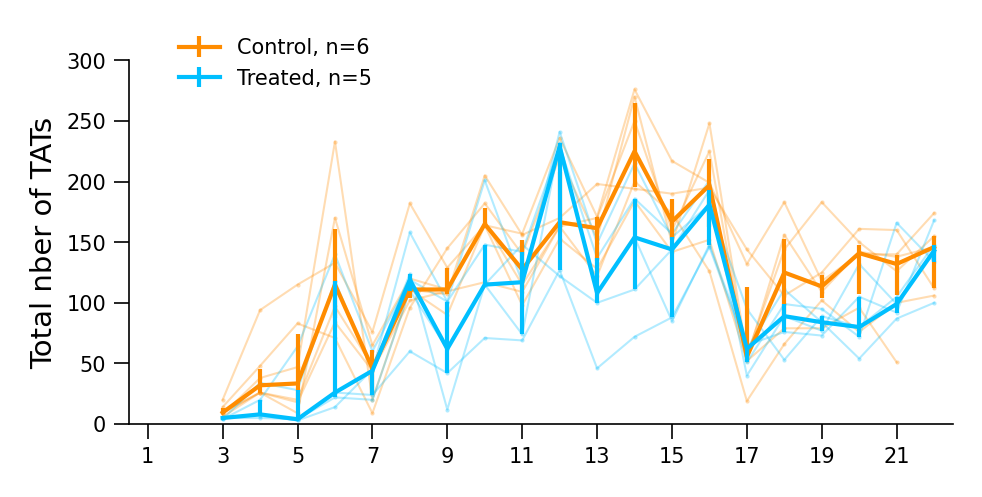

In [ ]:
main_lines_labels = [
    f'Control, n={len(mice_rewarded_tats_persession_1)}',
    f'Treated, n={len(mice_rewarded_tats_persession_2)}'

]


fig=plt.figure(figsize=(cm2inch(9), cm2inch(4)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(1, 1 , hspace=0.3)
row1 = gs[0].subgridspec(1, 1, wspace=.3, hspace=.3)
ax_1 = plt.subplot(row1[0])
plot_learning_curves([mice_rewarded_tats_persession_1,mice_rewarded_tats_persession_2], ax_1, show_individual_mice=True, colors= ['darkorange','deepskyblue'], main_lines_labels=main_lines_labels, show_xlabel = False, xlim=xlim_stats, ylim=[0,300], ylabel='Total nber of TATs', tick_interval=2, index_offset=session_index_offset, show_legend=True)
#plot_learning_curves(mice_unrewarded_tats_persession, ax_1, show_individual_mice=False, median_color= 'indigo', show_xlabel = False, xlim=xlim_stats, ylim=[0,300], ylabel='Total nber of TATs', main_line_label='Median unrewarded TATs \u00B1 Quartiles', tick_interval=2, index_offset=session_index_offset, show_legend=True)


6
5


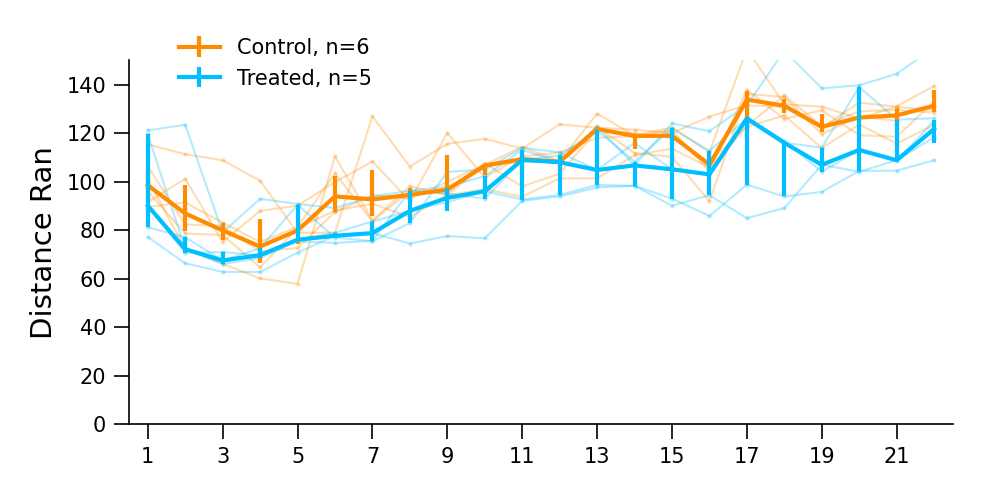

In [11]:
main_lines_labels = [
    f'Control, n={len(mice_rewarded_tats_persession_1)}',
    f'Treated, n={len(mice_rewarded_tats_persession_2)}'

]


fig=plt.figure(figsize=(cm2inch(9), cm2inch(4)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(1, 1 , hspace=0.3)
row1 = gs[0].subgridspec(1, 1, wspace=.3, hspace=.3)
ax_1 = plt.subplot(row1[0])
plot_learning_curves([mice_distance_run_persession_1,mice_distance_run_persession_2], ax_1, show_individual_mice=True, colors= ['darkorange','deepskyblue'], main_lines_labels=main_lines_labels, show_xlabel = False, xlim=xlim_stats, ylim=[0,150], ylabel='Distance Ran', tick_interval=2, index_offset=session_index_offset, show_legend=True)
#plot_learning_curves(mice_unrewarded_tats_persession, ax_1, show_individual_mice=False, median_color= 'indigo', show_xlabel = False, xlim=xlim_stats, ylim=[0,300], ylabel='Total nber of TATs', main_line_label='Median unrewarded TATs \u00B1 Quartiles', tick_interval=2, index_offset=session_index_offset, show_legend=True)


6
5
6
5
6
5
6
5
6
5


/tmp/ipykernel_15073/1093541462.py:187: RuntimeWarning: All-NaN slice encountered
  median_values.append(np.nanmedian(session_values))


6
5
6
5
6
5


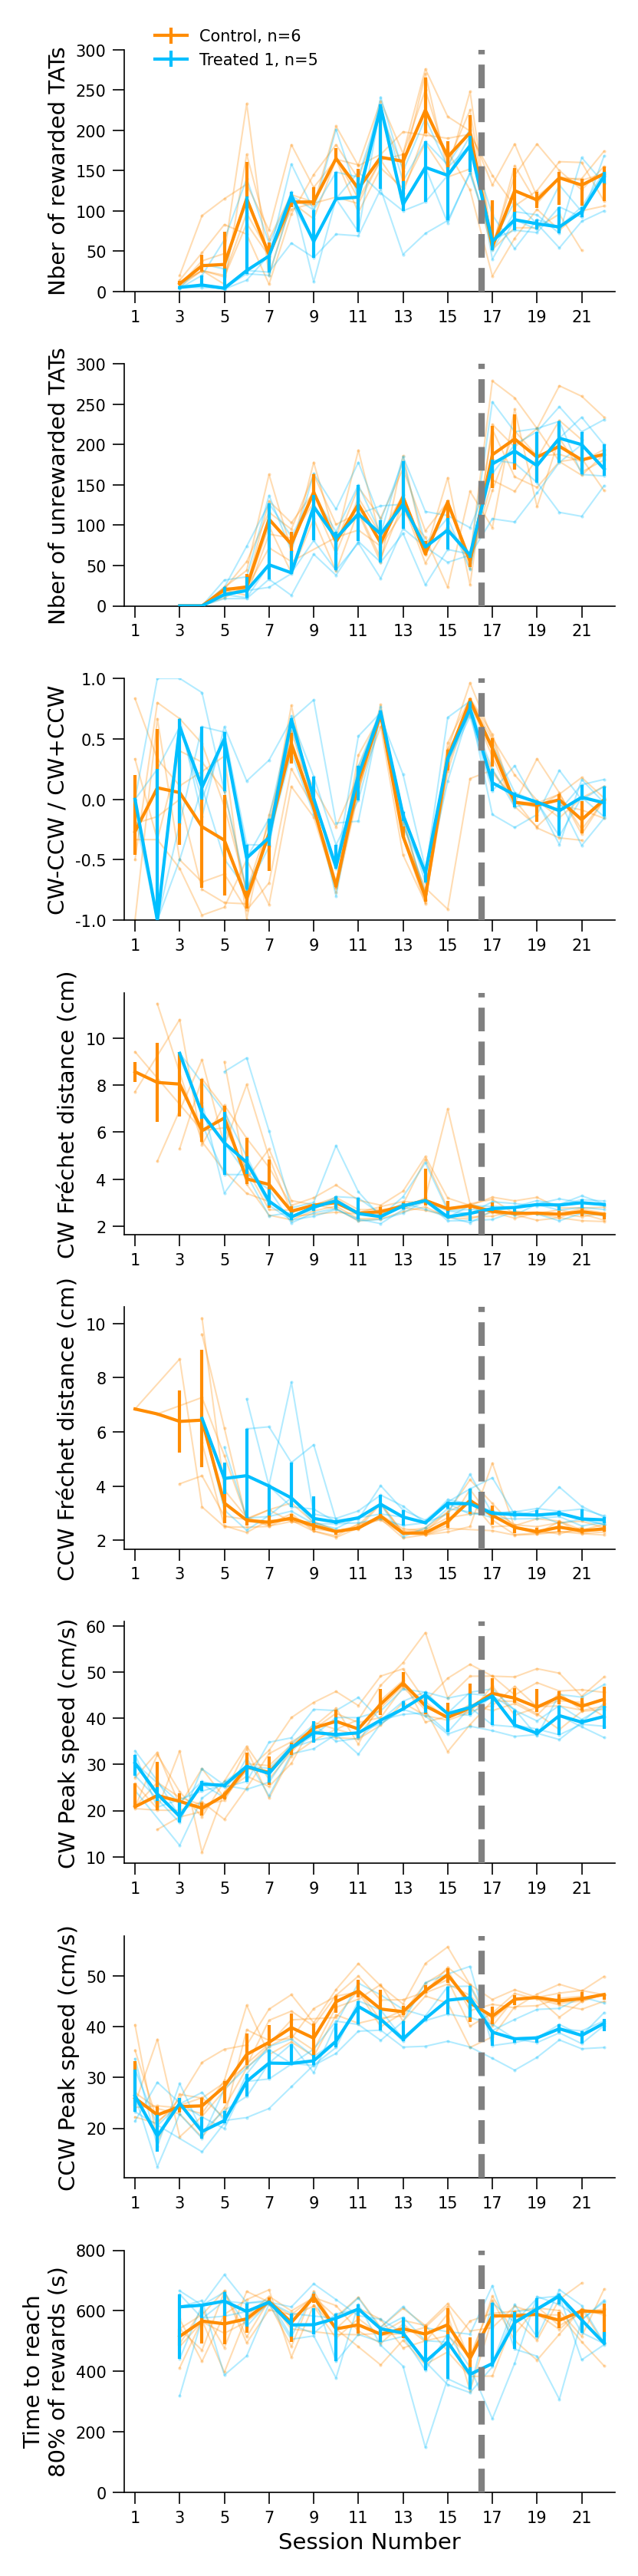

In [ ]:
switch_occurence = 16.5

fig=plt.figure(figsize=(cm2inch(7), cm2inch(35)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(8, 1 , hspace=0.3)

tick_interval = 4

main_lines_labels = [
    f'Control, n={len(mice_rewarded_tats_persession_1)}',
    f'Treated 1, n={len(mice_rewarded_tats_persession_2)}'

]

### Panel A ###
row1 = gs[0].subgridspec(1, 1)

ax_1 = plt.subplot(row1[:])

plot_learning_curves([mice_rewarded_tats_persession_1,mice_rewarded_tats_persession_2], ax_1, show_individual_mice=True, colors=['darkorange','deepskyblue'], show_xlabel = False, xlim=xlim_stats, ylim=[0,300], ylabel='Nber of rewarded TATs', main_lines_labels=main_lines_labels, tick_interval=2, index_offset=session_index_offset, show_legend=True)

# plot_learning_curves(mice_unrewarded_tats_persession, ax_1, show_individual_mice=False, median_color= 'indigo', show_xlabel = False, xlim=xlim_stats, ylim=[0,300], ylabel='Total nber of TATs', main_line_label='Unrewarded TATs', tick_interval=2, index_offset=session_index_offset, show_legend=True)

if switch_occurence:
    ax_1.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, label="Switch Reward direction", zorder=2000)

# handles, labels = plt.gca().get_legend_handles_labels()
# current_order = list(range(len(handles)))
# target_order = current_order[2:] + current_order[:2]
# ax_1.legend([handles[idx] for idx in target_order],[labels[idx] for idx in target_order], frameon=False, loc=(0.01, 1), ncols=2)

# fig.text(-0.02, 0.89, 'A', weight='bold', va='center', ha='center', fontsize=7)

###########################################

row2 = gs[1].subgridspec(1, 1)

ax_2 = plt.subplot(row2[:])

plot_learning_curves([mice_unrewarded_tats_persession_1,mice_unrewarded_tats_persession_2], ax_2, show_individual_mice=True, colors=['darkorange','deepskyblue'], show_xlabel = False, xlim=xlim_stats, ylim=[0,300], ylabel='Nber of unrewarded TATs', main_lines_labels=None, tick_interval=2, index_offset=session_index_offset, show_legend=False)

if switch_occurence:
    ax_2.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, label="Switch Reward direction", zorder=2000)


###########################################

row3 = gs[2].subgridspec(1, 1)

ax_3 = plt.subplot(row3[:])

plot_learning_curves([mice_cw_vs_ccw_norm_diff_persession_1,mice_cw_vs_ccw_norm_diff_persession_2], ax_3, show_individual_mice=True, show_xlabel = False, colors=['darkorange','deepskyblue'], xlim=xlim_stats, ylim=[-1,1], ylabel='CW-CCW / CW+CCW', tick_interval=2, index_offset=session_index_offset, main_lines_labels=None, show_legend=False, legend_loc=(0.25,0.25))


if switch_occurence:
    ax_3.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, zorder=2000)

# fig.text(-0.02, 0.73, 'B', weight='bold', va='center', ha='center', fontsize=7)

###########################################

row4 = gs[3].subgridspec(1, 1)

ax_4 = plt.subplot(row4[:])

plot_learning_curves([overall_cw_turns_frechet_distances_per_session_1,overall_cw_turns_frechet_distances_per_session_2], ax_4, show_individual_mice=True, xlim=xlim_stats, colors=['darkorange','deepskyblue'], main_lines_labels=None, show_xlabel = False, ylabel='CW Fréchet distance (cm)', tick_interval=2, index_offset=session_index_offset, show_legend=False)

if switch_occurence:
    ax_4.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, zorder=2000)

# fig.text(-0.02, 0.57, 'C', weight='bold', va='center', ha='center', fontsize=7)

###########################################

row5 = gs[4].subgridspec(1, 1)

ax_5 = plt.subplot(row5[:])

plot_learning_curves([overall_ccw_turns_frechet_distances_per_session_1,overall_ccw_turns_frechet_distances_per_session_2], ax_5, show_individual_mice=True, xlim=xlim_stats, colors=['darkorange','deepskyblue'], main_lines_labels=None, show_xlabel = False, ylabel='CCW Fréchet distance (cm)', tick_interval=2, index_offset=session_index_offset, show_legend=False)

if switch_occurence:
    ax_5.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, zorder=2000)


###########################################
row6 = gs[5].subgridspec(1, 1)

ax_6 = plt.subplot(row6[:])

plot_learning_curves([mice_median_maximum_cw_turn_speed_persession_1,mice_median_maximum_cw_turn_speed_persession_2], ax_6, show_individual_mice=True, colors= ['darkorange','deepskyblue'], show_xlabel = False, xlim=xlim_stats, ylabel='CW Peak speed (cm/s)', main_lines_labels=None, tick_interval=2, index_offset=session_index_offset, show_legend=False)

if switch_occurence:
    ax_6.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, zorder=2000)

# fig.text(-0.02, 0.41, 'D', weight='bold', va='center', ha='center', fontsize=7)

###########################################
row7 = gs[6].subgridspec(1, 1)

ax_7 = plt.subplot(row7[:])

plot_learning_curves([mice_median_maximum_ccw_turn_speed_persession_1,mice_median_maximum_ccw_turn_speed_persession_2], ax_7, show_individual_mice=True, colors= ['darkorange','deepskyblue'], show_xlabel = False, xlim=xlim_stats, ylabel='CCW Peak speed (cm/s)', main_lines_labels=None, tick_interval=2, index_offset=session_index_offset, show_legend=False)

if switch_occurence:
    ax_7.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, zorder=2000)

# fig.text(-0.02, 0.41, 'D', weight='bold', va='center', ha='center', fontsize=7)


### Panel E ###
row8 = gs[7].subgridspec(1, 1)

ax_8 = plt.subplot(row8[:])

plot_learning_curves([mice_rewarded_tats_threshold_persession_1, mice_rewarded_tats_threshold_persession_2], ax_8, colors= ['darkorange','deepskyblue'], show_individual_mice=True, show_xlabel = True, xlim=xlim_stats,ylim=[0,800] ,ylabel='Time to reach\n80% of rewards (s)', tick_interval=2, index_offset=session_index_offset, show_legend=False)

if switch_occurence:
    ax_8.axvline(switch_occurence, linestyle='--', color='grey', linewidth=2, zorder=2000)

# fig.text(-0.02, 0.25, 'E', weight='bold', va='center', ha='center', fontsize=7)

#plt.savefig("/home/david/Documents/code/4TowersTask/Figure4.png", facecolor='w', 
#                edgecolor='none', bbox_inches='tight', format="png", dpi=300)